# Library imports and directory mount

In [1]:
import matplotlib.pyplot as plt, numpy as np, pandas as pd, seaborn as sns, tensorflow as tf
import cv2, glob, os, random, sys, warnings

from google.colab import drive

from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

from skimage.segmentation import slic
from skimage.transform import resize

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score, f1_score, multilabel_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

warnings.filterwarnings('ignore') 

sns.set() # for ploting

drive.mount('/content/gdrive')

physicalDevices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physicalDevices[0], True)

Mounted at /content/gdrive


## Configuration variables

Index | Recommended configuration
:---: | :---:
1 | Rotation up to 20º<br>shear up to 15º<br>Horizontal and vertical flip<br>Vertical and horizontal shift up to 20%<br>Zoom out up to 20%
2 | Rotation up to 15º<br>Vertical and horizontal flip<br>Image resize up to 10%

In [2]:
### Environment
csvMetadataPath = "/content/gdrive/MyDrive/PUC/TCC/Datasets/ham10000/HAM10000_metadata.csv" # "HAM10000_metadata.csv"
imagesPath = "gdrive/MyDrive/PUC/TCC/Datasets/ham10000/imgs/" # "images"

### Height and weight of images to be crop
h, w = 224, 224

### Remove duplicates
removeDuplicates = True
removeNv = True
"""
0 0 10015
0 1 3310
1 0 5514
1 1 1099
"""

### Segmentation
segmentation = False
segmentationNum = 100
compactnessNum = 10

### Data augmentation
dataAugmentation = False
rotation = .45
widthShift, heightShift = .1, .1
channelShift = .15
shear = .2
zoom = .25
hFlip, vFlip = True, True
fill = 'nearest' # constant, nearest, reflect, wrap
cval = .5 # case the previous is constant
bright = [.6,1.4]

### Normalization
featureCenter = False
sampleCenter = False
featureStdNorm = False
sampleStdNorm = False
zcaWhitening = False
standardScalerNorm = False
minMaxScalerNorm = False

### Model configuration
epochs = 5
batchSize = 100
if removeNv:
    cancerType = {
        'akiec': 0, # 0.0 - 'Doenca de Bowens'
        'bcc': 1, # 1.0 - 'Carcinoma basocelular'
        'bkl': 2, # 2.0 - 'Keratose benigna'
        'df': 3, # 3.0 - 'Dermatofibroma'
        'vasc': 4, # 4.0 - 'Lesao vascular'
        'mel': 5, # 5.0 - 'Melanoma'
    }
    totalImages = 1099 if removeDuplicates else 3310
else:
    cancerType = {
        'akiec': 0, # 0.0 - 'Doenca de Bowens'
        'bcc': 1, # 1.0 - 'Carcinoma basocelular'
        'bkl': 2, # 2.0 - 'Keratose benigna'
        'df': 3, # 3.0 - 'Dermatofibroma'
        'vasc': 4, # 4.0 - 'Lesao vascular'
        'mel': 5, # 5.0 - 'Melanoma'
        'nv': 6  # 6.0 - 'Nevo melanocitico'
    }
    totalImages = 5514 if removeDuplicates else 10015
totalClasses = len(cancerType)
useCustomOptimizer = False

# Dataset import (CSV Metadata)

In [3]:
datasetMetadata = pd.read_csv(csvMetadataPath)
datasetMetadata = datasetMetadata.drop(columns=['dx_type','age','sex','localization'])
datasetMetadata = datasetMetadata.rename(columns={"lesion_id": "lesionId",
                                                  "image_id": "imageId",
                                                  "dx": "cancerId"})
datasetMetadata.head()

,lesionId,imageId,cancerId
0,HAM_0000118,ISIC_0027419,bkl
1,HAM_0000118,ISIC_0025030,bkl
2,HAM_0002730,ISIC_0026769,bkl
3,HAM_0002730,ISIC_0025661,bkl
4,HAM_0001466,ISIC_0031633,bkl


In [4]:
datasetMetadata['duplicate'] = datasetMetadata['lesionId']      # Creating a column to indicate if the lesion has more than one image

uniqueLesions = datasetMetadata.groupby('lesionId').count()     # Counts the number of lesions for each id
uniqueLesions = uniqueLesions[uniqueLesions['imageId'] == 1]    # Filter lesions which ones have unique id
uniqueLesions.reset_index(inplace=True)                         # Add default index column
uniqueLesions = uniqueLesions['lesionId'].values.tolist()       # Extracts the indexes into a list

datasetMetadata['duplicate'] = datasetMetadata['duplicate'].apply(lambda x: 0 if x in uniqueLesions else 1) # Fill the rows indicating if the lesion has a duplicated image
datasetMetadata['duplicate'].value_counts()

0    5514
1    4501
Name: duplicate, dtype: int64

Removing Duplicates

In [5]:
if removeDuplicates:
    datasetMetadata = datasetMetadata[datasetMetadata['duplicate'] == 0]
if removeNv:
    datasetMetadata = datasetMetadata[datasetMetadata['cancerId'] != 'nv']
datasetMetadata.head()

,lesionId,imageId,cancerId,duplicate
10,HAM_0001396,ISIC_0025276,bkl,0
15,HAM_0007207,ISIC_0031326,bkl,0
20,HAM_0006071,ISIC_0032343,bkl,0
33,HAM_0005612,ISIC_0024981,bkl,0
34,HAM_0005388,ISIC_0027815,bkl,0


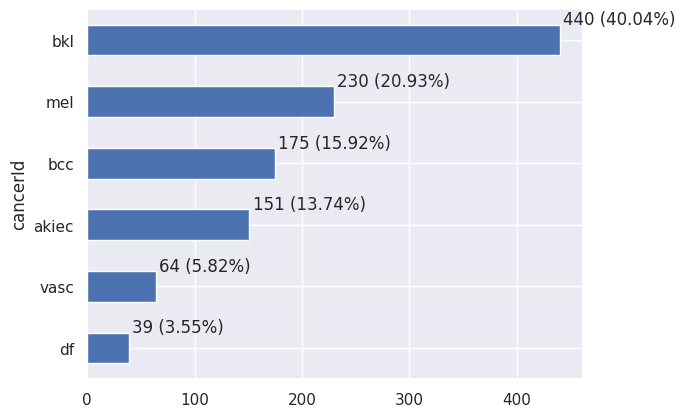

cancerId
df        39
vasc      64
akiec    151
bcc      175
mel      230
bkl      440
dtype: int64
Total:  1099


In [6]:
labelSize = datasetMetadata.groupby('cancerId').size().sort_values() # Sort and order every cancer class

ax = labelSize.plot.barh()

for i, v in enumerate(labelSize):
    ax.text(v + 3, i + .25, str(v) + ' (' + str(round(v/datasetMetadata.shape[0]*100, 2)) + '%)') # Set the percentage of each cancer class

plt.show()

print(labelSize)
print("Total: ",labelSize.sum())

In [7]:
datasetMetadata['cancerId'] = datasetMetadata['cancerId'].map(cancerType) # Map each class into an integer
datasetMetadata.head()

,lesionId,imageId,cancerId,duplicate
10,HAM_0001396,ISIC_0025276,2,0
15,HAM_0007207,ISIC_0031326,2,0
20,HAM_0006071,ISIC_0032343,2,0
33,HAM_0005612,ISIC_0024981,2,0
34,HAM_0005388,ISIC_0027815,2,0


# Dataset import (Imgs)

https://scikit-image.org/docs/stable/api/skimage.segmentation.html

In [8]:
# Path to the dataset images
# /content/gdrive/MyDrive/PUC/TCC/Datasets/ham10000/imgs/<imgId>.jpg

images = []
loadedImages = 0

for index, row in datasetMetadata.iterrows():
    img = cv2.imread(imagesPath+row['imageId']+'.jpg') # Collect the image from drive
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Invert color BGR => RGB
    if segmentation: # TODO: testar
        # Segment the image into superpixels using SLIC
        segments = slic(img, n_segments=segmentationNum, compactness=compactnessNum)

        # Resize the superpixels to widthxheight pixels
        resizedSegments = resize(segments, (w, h), order=0, anti_aliasing=False)

        # Reassemble the resized superpixels to form the resized image
        img = resize(img, resizedSegments.shape, order=3, anti_aliasing=True)
    else:
        img = cv2.resize(img, (h, w)) # Resize the image according to params provided
    images.append(img)
    
    loadedImages = loadedImages + 1
    if loadedImages % 1000 == 0:
        print(loadedImages)
del loadedImages

1000


1099
lesionId      HAM_0001396
imageId      ISIC_0025276
cancerId                2
duplicate               0
Name: 10, dtype: object
(224, 224, 3)


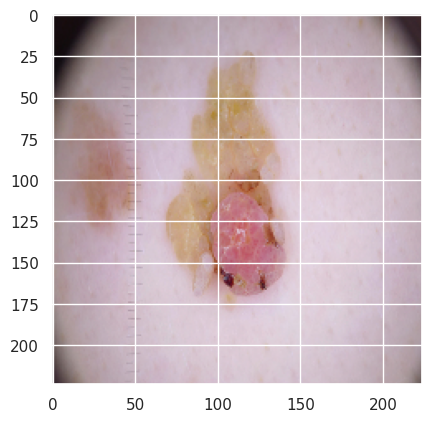

In [9]:
plt.imshow(images[0])
print(len(images))
print(datasetMetadata.iloc[0])
print(images[0].shape)
plt.show()

# Images treatment

In [10]:
images = np.array(images) # Transform images list into np array
print(images.shape)

images = images.reshape(totalImages, h * w * 3) # 4d -> 2d
print(images.shape)
print(images.dtype)

(1099, 224, 224, 3)
(1099, 150528)
uint8


## Model input treatment

Spliting in training, validation and test balancing the batches by the cancer id:

Train set = 70%

Validation set = 10%

Test set = 20%

In [11]:
XTrainVal, XTest, YTrainVal, YTest = train_test_split(images,datasetMetadata['cancerId'], test_size = 0.2, train_size = 0.8, stratify=datasetMetadata['cancerId'])
del images
XTrain, XVal, YTrain, YVal = train_test_split(XTrainVal,YTrainVal, test_size = 0.125, train_size = 0.875, stratify=YTrainVal)
del XTrainVal, YTrainVal

Normalization

In [12]:
if minMaxScalerNorm:
    minMaxScaler = MinMaxScaler()
    minMaxScaler.fit(np.asarray(XTrain))

    XTrain = minMaxScaler.transform(XTrain)
    XVal = minMaxScaler.transform(XVal)
    XTest = minMaxScaler.transform(XTest)
elif standardScalerNorm:
    standardScaler = StandardScaler()
    standardScaler.fit(np.asarray(XTrain))

    XTrain = standardScaler.transform(XTrain)
    XVal = standardScaler.transform(XVal)
    XTest = standardScaler.transform(XTest)

print(np.shape(XTest))
print(np.shape(XTrain))
print(np.shape(XVal))
print(YTrain.head())

(220, 150528)
(769, 150528)
(110, 150528)
566     2
275     2
2433    4
2024    5
554     2
Name: cancerId, dtype: int64


Resize

In [13]:
print(XTrain.shape[0])
print(XVal.shape[0])
print(XTest.shape[0])
XTrain = XTrain.reshape(XTrain.shape[0], h, w, 3).astype('float32')
XVal = XVal.reshape(XVal.shape[0], h, w, 3).astype('float32')
XTest = XTest.reshape(XTest.shape[0], h, w, 3).astype('float32')

YTrain = np_utils.to_categorical(YTrain)
YVal = np_utils.to_categorical(YVal)
YTest = np_utils.to_categorical(YTest)

print(XTrain[0].shape)
XTrain.dtype

769
110
220
(224, 224, 3)


dtype('float32')

### Data augmentation

Only be applied in the training set

In [14]:
if dataAugmentation:
    datagen = ImageDataGenerator(
            # Normalizations
            featurewise_center = featureCenter,
            samplewise_center = sampleCenter,
            featurewise_std_normalization = featureStdNorm,
            samplewise_std_normalization = sampleStdNorm,
            zca_whitening = zcaWhitening,
            # Image modifications
            rotation_range = rotation,
            zoom_range = zoom,
            channel_shift_range = channelShift,
            fill_mode = fill,
            cval = cval,
            width_shift_range = widthShift,
            height_shift_range = heightShift,
            horizontal_flip = hFlip,
            brightness_range = bright,
            shear_range = shear,
            vertical_flip = vFlip)

    print(XTrain.shape)
    print(XTrain.size)
    datagen.fit(XTrain)
    print(XTrain.shape)
    print(XTrain.size)

# Model training

Loading pre treined model

In [15]:
with tf.device('/GPU:0'): # Using GPU processing on model
    model = tf.keras.applications.ConvNeXtBase(weights='imagenet', include_top=False, classes=totalClasses, input_shape=(h,w,3))

    for layer in model.layers:
        layer.trainable = False

    prediction = tf.keras.layers.Dense(totalClasses, activation='softmax')(tf.keras.layers.Flatten()(model.output))

    model = tf.keras.Model(inputs=model.input, outputs=prediction)

    optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

    if useCustomOptimizer:
        model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
    else:
        model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics=["accuracy"])
    learningRateReduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

350926856/350926856 [==============================] - 17s 0us/step


validation_freq = [1,3,5]

In [16]:
with tf.device('/GPU:0'):
    if dataAugmentation:
        history = model.fit_generator(datagen.flow(XTrain,YTrain, batch_size=batchSize),
                                    epochs = epochs, validation_data = (XVal, YVal),
                                    verbose = 2, steps_per_epoch=XTrain.shape[0] // batchSize,
                                    callbacks=[learningRateReduction])
    else:
        history = model.fit(XTrain, YTrain, validation_data = (XVal, YVal), epochs=epochs, batch_size=batchSize, verbose = 2)

Epoch 1/5
8/8 - 65s - loss: 10.7758 - accuracy: 0.3108 - val_loss: 6.5583 - val_accuracy: 0.4455 - 65s/epoch - 8s/step
Epoch 2/5
8/8 - 15s - loss: 5.3461 - accuracy: 0.5358 - val_loss: 5.4604 - val_accuracy: 0.6364 - 15s/epoch - 2s/step
Epoch 3/5
8/8 - 15s - loss: 2.1332 - accuracy: 0.7308 - val_loss: 3.7139 - val_accuracy: 0.6182 - 15s/epoch - 2s/step
Epoch 4/5
8/8 - 15s - loss: 0.8743 - accuracy: 0.8609 - val_loss: 1.6355 - val_accuracy: 0.7364 - 15s/epoch - 2s/step
Epoch 5/5
8/8 - 16s - loss: 0.3188 - accuracy: 0.9285 - val_loss: 1.6279 - val_accuracy: 0.7727 - 16s/epoch - 2s/step


# Statistics

Training epochs statistics

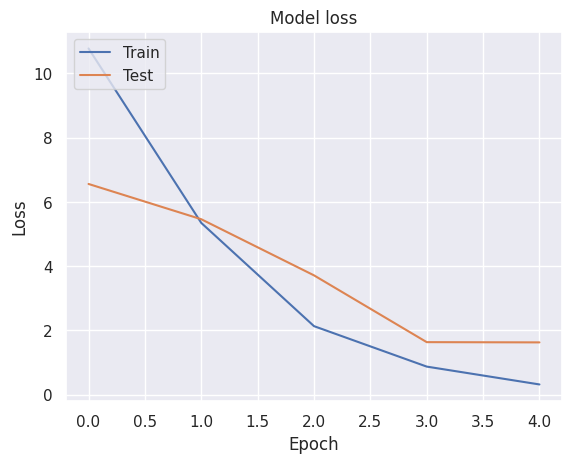

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

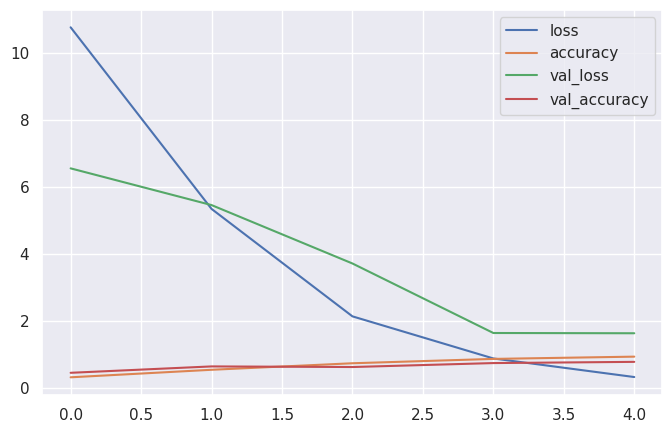

In [18]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

General eficiency

In [19]:
YPredicted = model.predict(XTest)
print(model.evaluate(XTest, YTest, verbose=0))
print(model.evaluate(XVal, YVal, verbose=0))

7/7 [==============================] - 18s 1s/step
[3.3403866291046143, 0.6181818246841431]
[1.6279014348983765, 0.7727272510528564]


Confusion matrix

Text(0.5, 93.24999999999997, 'Predicted label')

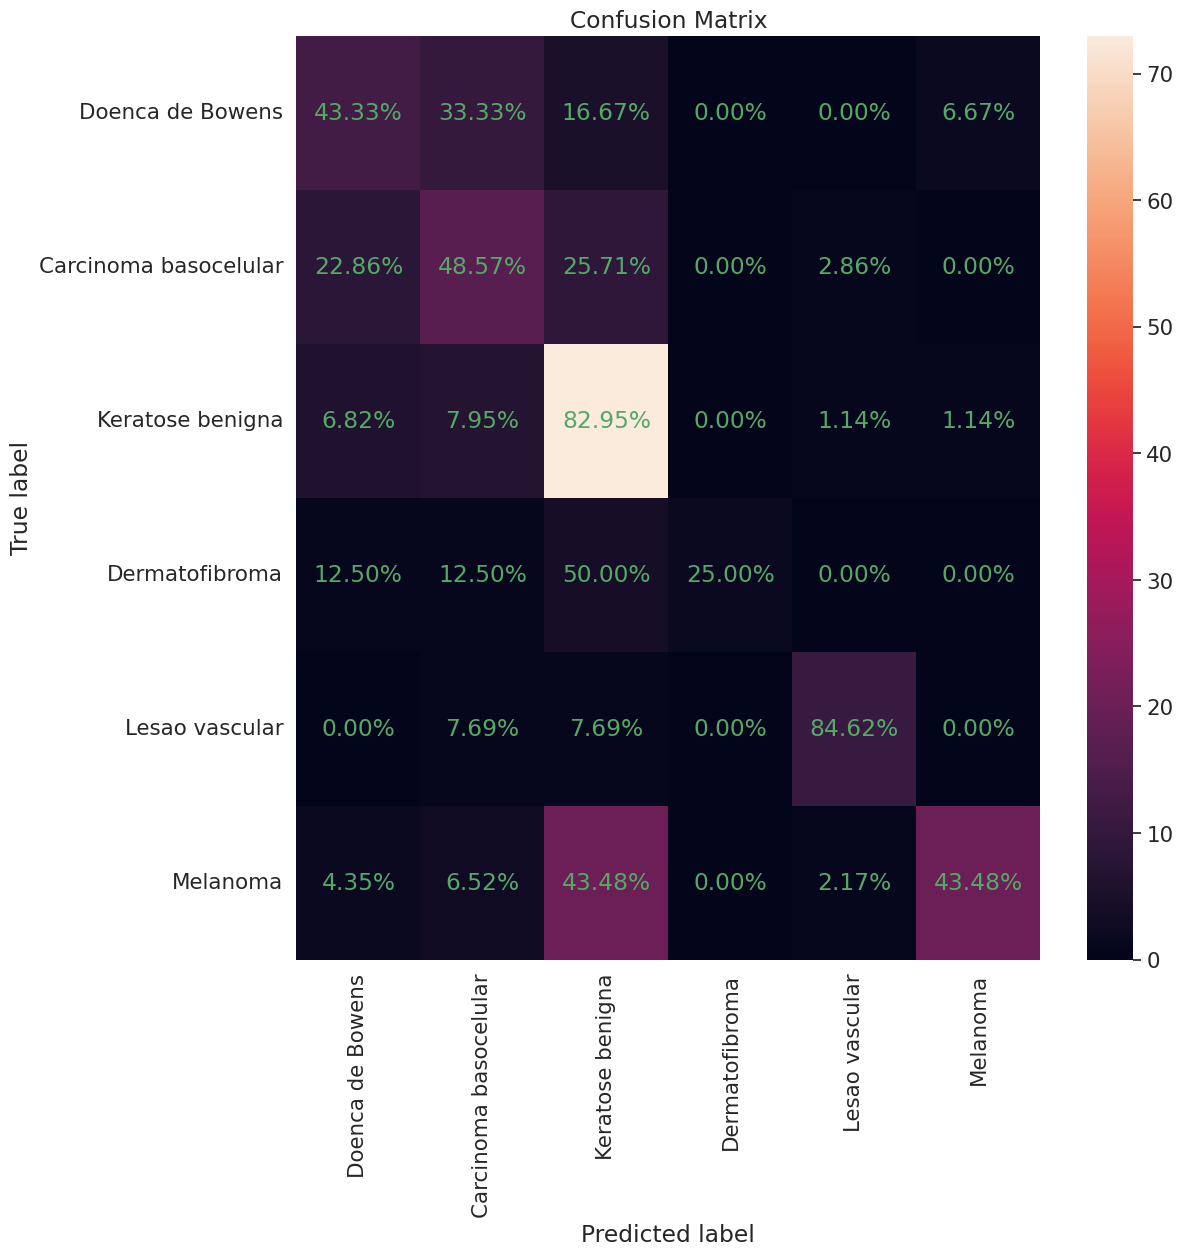

In [20]:
cm = confusion_matrix(YTest.argmax(axis=1),YPredicted.argmax(axis=1))
# TODO: Traduzir
class_labels = ['Doenca de Bowens', 'Carcinoma basocelular', 'Keratose benigna', 'Dermatofibroma', 'Lesao vascular', 'Melanoma']
dfCm = pd.DataFrame(cm, index=class_labels, columns=class_labels)

plt.figure(figsize = (12,12))
sns.set(font_scale=1.4) # Label size
sns.heatmap(dfCm, annot=False, annot_kws={"size": 12}) # Font size

for i in range(totalClasses):
    for j in range(totalClasses):
        text = plt.text(j + 0.5, i + 0.5, "{:.2f}%".format(cm[i, j] / cm[i].sum() * 100), va="center", ha="center", color="g")

plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

Metrics

In [21]:
print("Accuracy: ", accuracy_score(np.argmax(YTest, axis=1), np.argmax(YPredicted, axis=1)))
# TODO: formatar para cada classe
print("Precision: ", precision_score(np.argmax(YTest, axis=1), np.argmax(YPredicted, axis=1), average=None))

print("Recall: ", recall_score(np.argmax(YTest, axis=1), np.argmax(YPredicted, axis=1), average=None))

print("F1-score: ", f1_score(YTest.argmax(axis=1), YPredicted.argmax(axis=1), average=None),"\n")

print("ROC AUC score: ", roc_auc_score(YTest, YPredicted, average=None))

cmMulti = multilabel_confusion_matrix(YTest.argmax(axis=1),YPredicted.argmax(axis=1))
specificity = []
for i in range(len(cmMulti)):
    print('\n',cmMulti[i])
    tn = cmMulti[i][0][0]
    fp = cmMulti[i][0][1]
    specificity.append(tn / (tn + fp))
print("\nSpecificity: ", specificity)

Accuracy:  0.6181818181818182
Precision:  [0.43333333 0.43589744 0.65178571 1.         0.78571429 0.86956522]
Recall:  [0.43333333 0.48571429 0.82954545 0.25       0.84615385 0.43478261]
F1-score:  [0.43333333 0.45945946 0.73       0.4        0.81481481 0.57971014] 

ROC AUC score:  [0.80473684 0.85312741 0.84732266 0.95636792 0.97324415 0.86956522]

 [[173  17]
 [ 17  13]]

 [[163  22]
 [ 18  17]]

 [[93 39]
 [15 73]]

 [[212   0]
 [  6   2]]

 [[204   3]
 [  2  11]]

 [[171   3]
 [ 26  20]]

Specificity:  [0.9105263157894737, 0.8810810810810811, 0.7045454545454546, 1.0, 0.9855072463768116, 0.9827586206896551]


Saving model into google drive

In [22]:
model.save('/content/gdrive/MyDrive/PUC/TCC/Notebooks/convNext7classes.h5')